In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$Ax=y$

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [138]:
y = np.dot(A, x)

$A$ ist invertierbar:

In [5]:
np.linalg.inv(A)

array([[ 0.58611217,  0.22754722,  0.22079958, ..., -0.35934623,
         0.66178901,  0.19085717],
       [-0.86053578,  0.35823913, -0.05086583, ..., -0.28753986,
         0.01246512, -1.48921599],
       [ 0.26764428, -0.13717687, -0.92694754, ...,  0.09591585,
        -1.22390556,  2.1684163 ],
       ...,
       [ 0.66359634, -0.39434052,  0.53305901, ...,  0.12365094,
         0.66198343,  0.04954313],
       [-0.06110287,  0.01871632, -0.28590078, ...,  0.03731371,
        -0.48258655,  0.91014539],
       [-1.43651032,  0.47662975, -0.21419412, ..., -0.01676364,
         0.36827009, -2.7539353 ]])

Verlustfunktion: quadratischer Fehler $\Vert y - \hat{y}\Vert^2$

In [6]:
def squared_error(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-2(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
squared_error(y, np.mean(y))

222.12952243689784

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 100
randomization = False

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(squared_error(y, np.dot(A, param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

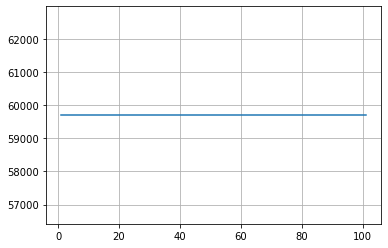

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()

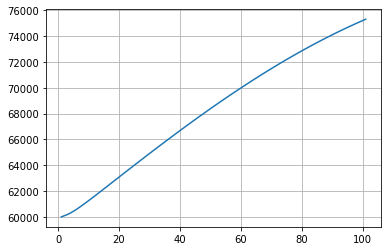

In [18]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.show()

## EnKF wie für inverse Probleme

Noise macht das Ergebnis kaputt.

In [214]:
noise = False
y = np.dot(A, x)
stddev_noise = np.ones(shape = y.shape)
if noise:
    noises = np.random.normal(loc = 0, scale = stddev_noise, size = y.shape)
    y = y + noises
    gamma = np.diag(stddev_noise**2)

In [215]:
batch = True
if batch:
    epochs = 10
    batch_size = 10         
else:
    epochs = 100
    batch_size = y.shape[0]

In [216]:
n = y.shape[0]
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [217]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [218]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [219]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [220]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [221]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [squared_error(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

In [222]:
for epoch in range(epochs):

    A_batches = [A[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    y_batches = [y[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    gamma_batches = [gamma[int(batch_indices[i]):int(batch_indices[i+1]),int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]

    for b in range(num_batches):

        # update the predictions and the loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
            loss_dict["particle_{}".format(i+1)] = squared_error(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrices C
        param_diff_dict = {}
        pred_diff_param_dict = {}
        pred_diff_w_dict = {}
        c_param_w_dict = {}
        c_w_w_dict = {}

        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
            pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
            pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
            c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
            c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
        c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

        # write the updates back into the dictionary
        for i in range(particles):
            if noise:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w + gamma_batches[b])), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])
            else:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])

        # compute loss for the parameter means
        param_mean = np.mean(list(param_dict.values()), axis = 0)
        loss_evolution.append(squared_error(y_batches[b], np.dot(A_batches[b], param_mean)))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(squared_error(y_batches[b], np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])))

In [223]:
loss_evolution

[60324.846883607024,
 282.139306600996,
 249.73948111888657,
 169.89768714572622,
 88.0437876959679,
 75.90833028665503,
 106.25878819954791,
 77.86882144990291,
 93.06110007163085,
 43.20843115099872,
 69.0077366035331,
 100.52578009920886,
 89.93091407312212,
 78.56970743368373,
 36.530235941319745,
 48.42283174192808,
 65.6597371769307,
 48.682744070250386,
 57.471900926533756,
 23.319687232811788,
 43.890377846374676,
 79.79049743501366,
 63.78393585814038,
 61.474912687409265,
 26.90503003013629,
 44.689720659362656,
 54.745899518155255,
 41.8849230655268,
 46.33535887933059,
 18.343448919906347,
 35.23207108579337,
 70.24206265695766,
 51.78881262792868,
 53.83111257001359,
 22.74146743944145,
 43.6486788468411,
 49.739238341781615,
 39.2127835391769,
 40.82593871311767,
 16.39850745118729,
 30.97735057261464,
 64.4690005484519,
 44.65525003486477,
 49.479244469976024,
 20.38803070024149,
 43.3274299258007,
 47.00337544463439,
 37.96431879119961,
 37.555664172014154,
 15.49606755

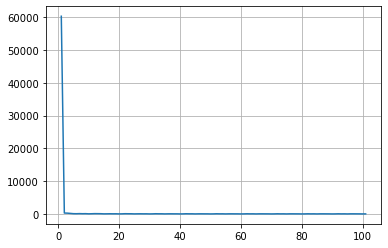

In [224]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()

Bei Berechnung mit Batches: Oszillationen kommen von den Batches. Für jede Batch ist es aber wieder monoton fallend.

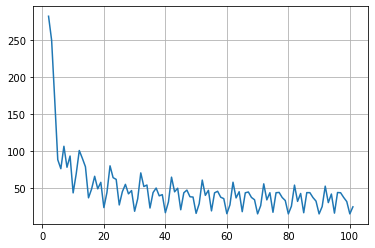

In [225]:
# ohne den initialen Guess
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.show()

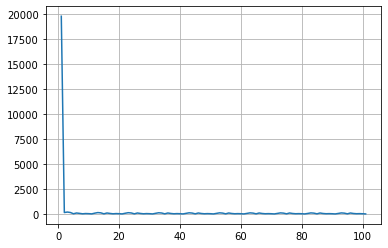

In [226]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.show()

In [227]:
np.dot(A, param_mean)

array([23.07012015, 26.79636502, 21.28080444, 23.76261969, 25.21952438,
       25.80475491, 20.96465967, 24.30089818, 21.79763904, 21.82365475,
       25.41095996, 28.51167461, 21.73641839, 26.27411918, 25.24170514,
       24.79893021, 24.54938208, 21.32358699, 26.35158876, 22.07084948,
       23.66450331, 24.25688754, 23.29277976, 25.67297746, 22.49042336,
       23.93313139, 22.96965722, 27.66191495, 23.22754893, 27.37422956,
       23.32132488, 24.1830742 , 24.68830467, 24.49554085, 27.05702458,
       23.44847195, 24.19759601, 23.74143291, 25.04460427, 21.00431171,
       27.19027754, 23.22792055, 22.24034022, 27.41408391, 25.49905294,
       25.0789396 , 29.08385543, 20.39587709, 22.34055182, 26.78615933,
       21.50673785, 28.63770728, 26.49661489, 22.45240529, 23.43195963,
       23.40287806, 23.0156416 , 26.96671402, 24.12670068, 22.99933995,
       23.8463325 , 22.81348431, 26.29955896, 23.40577339, 25.83633985,
       23.94250362, 24.29630191, 24.38523878, 28.19249281, 23.30

In [228]:
y

array([24.93864062, 24.09099148, 26.25305628, 24.05640439, 24.64454397,
       28.16979309, 21.67023114, 26.97393195, 22.24643928, 23.35476629,
       27.45352245, 28.53033815, 24.320793  , 27.63236822, 26.14936327,
       24.90531817, 26.07236955, 24.33898551, 26.91819902, 24.20534451,
       25.79499432, 25.88499083, 24.38543291, 25.83176522, 26.83586517,
       24.80273558, 22.71865125, 25.45981492, 26.10706738, 26.89293316,
       24.56265758, 24.8690558 , 23.51943907, 26.20412968, 27.53174095,
       25.37415973, 22.81567239, 25.32572346, 25.50640985, 22.03874206,
       25.24601192, 25.36932264, 24.53813854, 24.3565557 , 25.45253073,
       25.72562487, 26.47877767, 23.9623008 , 23.17563746, 26.54070402,
       23.38731952, 25.96615031, 24.79512153, 25.96092475, 23.95455273,
       24.66617169, 24.75855335, 26.37392893, 24.86833134, 26.45302213,
       26.41893908, 23.37025624, 25.94386236, 25.1289184 , 26.35923403,
       23.85443521, 25.14067224, 26.29386487, 23.66160306, 24.53